# Create a watershed model

Hydrological models typically need geographical information about watersheds being simulated: latitude and longitude, area, mean altitude, land-use, etc. This notebook shows how to obtain this information using remote services that are made available for users in PAVICS-Hydro. These services connect to a digital elevation model (DEM) and a land-use data set to extract relevant information.

The DEM used in the following is the [EarthEnv-DEM90](https://www.earthenv.org/DEM), while the land-use dataset is the [North American Land Change Monitoring System](http://www.cec.org/tools-and-resources/north-american-environmental-atlas/north-american-land-change-monitoring-system). Other data sources could be used, given their availability through the Web Coverage Service (WCS) protocol.

Since these computations happen on a specific Geoserver hosted in PAVICS, we need to establish a connection to that service. While the steps are a bit more complex, the good news is that you only need to change a few items in this notebook to taylor results to your needs. For example, this first code snippet is boilerplate and should not be changed.

We will also setup a hydrological model, calibrate it, and save the parameters for future use.

We will be using the Mistassini river as the test-case for this example, but you can substitute the data for any catchment of your liking. We provide:

1- Streamflow observations (Water Survey Canada station 02RD003)

2- Watershed boundaries in the form of shapefiles (all shape files .shp, .shx, .prj, .dbf, etc. zipped into a single file. The platform will detect and unzip the file to extract the required data)

The rest will be done by PAVICS-Hydro.

,features,Name,OfficialID,FlagPAVICS,Source,Area,geometry
0,1,MISTASSINI (RIVIERE) EN AMONT DE LA RIVIERE MI...,02RD003,1,HYDAT,9870,"POLYGON ((-72.26250 48.87917, -72.27720 48.881..."


<AxesSubplot:>

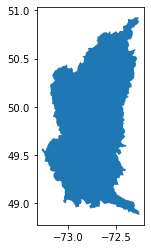

In [1]:
# We need to import a few packages required to do the work
import json
import os
import warnings
from zipfile import ZipFile

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rioxarray as rio
import xarray as xr
from birdy import WPSClient

# The platform provides lots of user warnings and information points. We will disable them for now.
warnings.filterwarnings("ignore")

# This is the URL of the Geoserver that will perform the computations for us.
url = os.environ.get(
    "WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
)

# Connect to the PAVICS-Hydro Raven WPS server
wps = WPSClient(url)

# Name of the watershed boundaries file that is uploaded to the server
feature_url = "shapefile_basin_574_HYSETS.zip"

# Prepare a plot of the catchment
df = gpd.read_file(feature_url)
display(df)
df.plot()

## Generic watershed properties

Now that we have delineated a watershed, lets find the zonal statistics and other properties using the `shape_properties` process. This process requires a `shape` argument defining the watershed contour, the exterior polygon.

Once the process has completed, we extract the data from the response, as follows. Note that you do not need to change anything here. The code will work and return the desired results.

In [2]:
shape_resp = wps.shape_properties(shape=feature_url)

[
    properties,
] = shape_resp.get(asobj=True)
prop = properties[0]
display(prop)

area = prop["area"] / 1000000.0
longitude = prop["centroid"][0]
latitude = prop["centroid"][1]
gravelius = prop["gravelius"]
perimeter = prop["perimeter"]

shape_info = {
    "area": area,
    "longitude": longitude,
    "latitude": latitude,
    "gravelius": gravelius,
    "perimeter": perimeter,
}
display(shape_info)

{'id': '0',
 'features': 1,
 'Name': 'MISTASSINI (RIVIERE) EN AMONT DE LA RIVIERE MISTASSIBI',
 'OfficialID': '02RD003',
 'FlagPAVICS': 1,
 'Source': 'HYDAT',
 'Area': 9870,
 'area': 9569366229.461872,
 'centroid': [-72.7431067594341, 49.848278236356585],
 'perimeter': 727186.8545423769,
 'gravelius': 2.0970051622223544}

{'area': 9569.366229461872,
 'longitude': -72.7431067594341,
 'latitude': 49.848278236356585,
 'gravelius': 2.0970051622223544,
 'perimeter': 727186.8545423769}

Note that these properties are a mix of the properties of the original file where the shape is stored, and properties computed by the process (area, centroid, perimeter and gravelius). Note also that the computed area is in m², while the "SUB_AREA" property is in km², and that there are slight differences between the two values due to the precision of HydroSHEDS and the delineation algorithm.

## Land-use information

Now we extract the land-use properties of the watershed using the `nalcms_zonal_stats` process. As mentionned, it uses the [North American Land Change Monitoring System](http://www.cec.org/tools-and-resources/north-american-environmental-atlas/north-american-land-change-monitoring-system) dataset, and retrieve properties over the given region.

With the `nalcms_zonal_stats_raster` process, we also return the grid with variable accessors (`gdal`, `rasterio`, or `rioxarray`) depending on what libraries are available in our runtime environment (The following examples show `rioxarray`-like access).

In [3]:
stats_resp = wps.nalcms_zonal_stats_raster(
    shape=feature_url, select_all_touching=True, band=1, simple_categories=True
)

Here we will get the raster data and compute statistics on it. It is also possible to download the extracted raseter offline (please see the tutorial for the steps on how to do this).

In [4]:
features, statistics, grid0 = stats_resp.get(asobj=True)
lu = statistics[0]
total = sum(lu.values())

land_use = {k: (v / total) for (k, v) in lu.items()}
display("Land use ratios", land_use)

land_use_pct = {k: f"{np.round(v/total*100, 2)} %" for (k, v) in lu.items()}
display("Land use percentages", land_use_pct)

'Land use ratios'

{'Ocean': 0.0,
 'Forest': 0.7246596208414477,
 'Shrubs': 0.14616312094792794,
 'Grass': 0.04322426804857576,
 'Wetland': 0.013300924493021603,
 'Crops': 0.00395034960218003,
 'Urban': 0.0035571063310866975,
 'Water': 0.06514460973576021,
 'SnowIce': 0.0}

'Land use percentages'

{'Ocean': '0.0 %',
 'Forest': '72.47 %',
 'Shrubs': '14.62 %',
 'Grass': '4.32 %',
 'Wetland': '1.33 %',
 'Crops': '0.4 %',
 'Urban': '0.36 %',
 'Water': '6.51 %',
 'SnowIce': '0.0 %'}

## Terrain information from the DEM

Here we collect terrain data, such as elevation, slope and aspect, from the DEM. We will do this using the `terrain_analysis` WPS service, which by default uses DEM data from [EarthEnv-DEM90](https://www.earthenv.org/DEM).

Note here that while the feature outline is defined above in terms of geographic coordinates (latitude, longitude), the DEM is projected onto a 2D cartesian coordinate system (here NAD83, the Canada Atlas Lambert projection). This is necessary to perform slope calculations. For more information on this, see: https://en.wikipedia.org/wiki/Map_projection

The DEM data returned in the process response here shows `rioxarray`-like access but using the URLs we can open the files however we like.

In [5]:
terrain_resp = wps.terrain_analysis(
    shape=feature_url, select_all_touching=True, projected_crs=3978
)

properties, dem0 = terrain_resp.get(asobj=True)

elevation = properties[0]["elevation"]
slope = properties[0]["slope"]
aspect = properties[0]["aspect"]

terrain = {"elevation": elevation, "slope": slope, "aspect": aspect}
display(terrain)

{'elevation': 423.6657935442332,
 'slope': 3.949426174669343,
 'aspect': 148.5591531205915}

## Overview

A synthesis of all watershed properties can be created by merging the various dictionaries created. This allows users to easily access any of these values, and to provide them to a Raven model as needed.

In [6]:
all_properties = {**shape_info, **land_use, **terrain}
display(all_properties)

{'area': 9569.366229461872,
 'longitude': -72.7431067594341,
 'latitude': 49.848278236356585,
 'gravelius': 2.0970051622223544,
 'perimeter': 727186.8545423769,
 'Ocean': 0.0,
 'Forest': 0.7246596208414477,
 'Shrubs': 0.14616312094792794,
 'Grass': 0.04322426804857576,
 'Wetland': 0.013300924493021603,
 'Crops': 0.00395034960218003,
 'Urban': 0.0035571063310866975,
 'Water': 0.06514460973576021,
 'SnowIce': 0.0,
 'elevation': 423.6657935442332,
 'slope': 3.949426174669343,
 'aspect': 148.5591531205915}

## Getting input data

Now that we have all the geographic information for our watershed, we can get the input meteorological data required to calibrate and run the model. Here we use an in-house solution that keeps updated ERA5 reanalysis datasets available with little to no wait.

In [7]:
import datetime as dt

import fsspec
import intake
import s3fs
from clisops.core import subset

# This will be our input section, where we control what we want to extract.
# We know which watershed interests us, it is the shapefile we used to get geographic data:

basin_contour = "shapefile_basin_574_HYSETS.zip"  # Contains .shp, .shx and other shapefile extension files

# Also, we can specify which timeframe we want to extract. Here let's focus on a 10-year period
reference_start_day = dt.datetime(1980, 12, 31)
reference_stop_day = dt.datetime(1991, 1, 1)
# Notice we are using one day before and one day after the desired period of 1981-01-01 to 1990-12-31.
# This is to account for any UTC shifts that might require getting data in a previous or later time.


# Get the ERA5 data from the Wasabi/Amazon S3 server.
catalog_name = "https://raw.githubusercontent.com/hydrocloudservices/catalogs/main/catalogs/atmosphere.yaml"
cat = intake.open_catalog(catalog_name)
ds = cat.era5_reanalysis_single_levels.to_dask()

"""
Get the ERA5 data. We will rechunk it to a single chunck to make it compatible with other codes on the platform, especially bias-correction.
We are also taking the daily min and max temperatures as well as the daily total precipitation.
"""
# We will add a wrapper to ensure that the following operations will preserve the original data attributes, such as units and variable names.
with xr.set_options(keep_attrs=True):
    ERA5_reference = subset.subset_shape(
        ds.sel(time=slice(reference_start_day, reference_stop_day)), basin_contour
    )
    ERA5_tmin = ERA5_reference["t2m"].resample(time="1D").min().chunk(-1, -1, -1)
    ERA5_tmax = ERA5_reference["t2m"].resample(time="1D").max().chunk(-1, -1, -1)
    ERA5_pr = ERA5_reference["tp"].resample(time="1D").sum().chunk(-1, -1, -1)

    # Change the units
    ERA5_tmin = ERA5_tmin - 273.15  # K to °C
    ERA5_tmin.attrs["units"] = "degC"

    ERA5_tmax = ERA5_tmax - 273.15  # K to °C
    ERA5_tmax.attrs["units"] = "degC"

    ERA5_pr = ERA5_pr * 1000  # m to mm
    ERA5_pr.attrs["units"] = "mm"

    # Average the variables spatially
    ERA5_tmin = ERA5_tmin.mean({"latitude", "longitude"})
    ERA5_tmax = ERA5_tmax.mean({"latitude", "longitude"})
    ERA5_pr = ERA5_pr.mean({"latitude", "longitude"})

    # Ensure that the precipitation is non-negative, which can happen with some reanalysis models.
    ERA5_pr[ERA5_pr < 0] = 0

    # Transform them to a dataset such that they can be written with attributes to netcdf
    ERA5_tmin = ERA5_tmin.to_dataset(name="tmin", promote_attrs=True)
    ERA5_tmax = ERA5_tmax.to_dataset(name="tmax", promote_attrs=True)
    ERA5_pr = ERA5_pr.to_dataset(name="pr", promote_attrs=True)

    # Write to disk.
    ERA5_tmin.to_netcdf("ERA5_tmin.nc")
    ERA5_tmax.to_netcdf("ERA5_tmax.nc")
    ERA5_pr.to_netcdf("ERA5_pr.nc")

## Set-up the hydrological model

Now that we have geographic and meteorological input data available, we can setup a Raven hydrological model and calibrate it. Many more details can be found in the documentation and tutorial notebooks. Note that the cell will take a bit of time to run as the model is being calibrated. 

In [8]:
# Import the template for our model, which will be the GR4J model with the CemaNeige snow model in our case.
from ravenpy.models import GR4JCN, GR4JCN_OST

# Combine the input and streamflow data into a single element that will be passed to Raven
forcing = ("ERA5_tmax.nc", "ERA5_tmin.nc", "ERA5_pr.nc", "Qobs_574_HYSETS.nc")

# Using Ostrich with the GR4JCN model. Start by creating the calibration model
model = GR4JCN_OST()

# Create the HRU for the watershed
hru = GR4JCN.LandHRU(
    area=all_properties["area"],
    elevation=all_properties["elevation"],
    latitude=all_properties["latitude"],
    longitude=all_properties["longitude"],
)

# Establish the start date for the calibration
import datetime as dt

start_date = dt.datetime(1981, 1, 1)
end_date = dt.datetime(1985, 12, 31)

# Starting point parameters. We can provide this to help accelerate the calibration process, but they are not strictly necessary.
params = (0.529, -3.396, 407.29, 1.072, 16.9, 0.053)

# lower and upper bounds for the parameters. Note that there are 6 values, each corresponding to the GR4JCN parameter in that position.
lower = (0.01, -15.0, 10.0, 0.0, 1.0, 0.0)
upper = (2.5, 10.0, 700.0, 7.0, 30.0, 1.0)

# Optimization algorithm. Multiple options are available, see OSTRICH documentation for more information. Here, DDS is used as it is powerful and
# particularly useful for optimizations with small evaluation budgets. See:
#
# Tolson, B.A. and Shoemaker, C.A., 2007. Dynamically dimensioned search algorithm for computationally efficient watershed model calibration. Water
# Resources Research, 43(1)
#
# for more details.
algorithm = "DDS"

# Maximum number of model evaluations. We only use 200 here to keep the computation time as low as possible, but you will want to increase this
# for operational use, perhaps to 500 or 1000.
max_iterations = 200

# Random seed. We will provide one for consistency purposes, but operationnaly this should not be provided.
random_seed = 0

# Here is where we launch the model calibration with the desired parameters and options. The process builds the model in the background and will return optimized parameters.
model(
    ts=forcing,
    hrus=(hru,),
    start_date=start_date,
    end_date=end_date,
    params=params,
    lowerBounds=lower,
    upperBounds=upper,
    algorithm=algorithm,
    random_seed=random_seed,  # Remove this for operational use!
    max_iterations=max_iterations,
    overwrite=True,
)

# Get the model diagnostics including Nash-Sutcliffe Efficiency
d = model.diagnostics

# Print the NSE and the parameter set in 2 different ways:
print("Nash-Sutcliffe value is: " + str(d["DIAG_NASH_SUTCLIFFE"]))
print(model.calibrated_params)  # With explanations of what these parameters are
print(
    model.optimized_parameters
)  # Just the array that could be used in another process. This is what people will typically want to use.

Nash-Sutcliffe value is: [0.6901]
GR4JCN.Params(GR4J_X1=0.05489502, GR4J_X2=5.117167, GR4J_X3=555.5967, GR4J_X4=4.135658, CEMANEIGE_X1=25.37618, CEMANEIGE_X2=0.8970489)
[5.489502e-02 5.117167e+00 5.555967e+02 4.135658e+00 2.537618e+01
 8.970489e-01]


## Run the calibrated hydrological model on a validation period

Now that the hydrological model has been calibrated, we can use these parameters to run the model on an independent period for validation

In [9]:
# Instantiate a GR4JCN model
model_validation = GR4JCN()

# Run the model with validation period dates and data, as well as calibrated parameters. Notice that the forcing data stays the same: Raven will select the data of the correct dates from the forcing data.
model_validation(
    ts=forcing,
    start_date=dt.datetime(1986, 1, 1),
    end_date=dt.datetime(1990, 12, 31),
    hrus=(
        hru,
    ),  # Careful how this must be passed! This is due to the capability of running in distributed mode as well.
    params=model.optimized_parameters,
    overwrite=True,  # OPTIONAL: We can do this to overwrite old files with the new ones generated in this run (output files, etc.)
)

# plot the diagnostics so we can see the validation Nash-Sutcliffe Efficiency:
model_validation.diagnostics

defaultdict(list,
            {'observed data series': ['HYDROGRAPH_ALL'],
             'filename': ['Qobs_574_HYSETS.nc'],
             'DIAG_NASH_SUTCLIFFE': [0.485837],
             'DIAG_RMSE': [136.853]})

## Save parameters and properties for future use

We can now save the calibrated parameters and basin properties for use in the second example, where we will look at the impacts of climate change.

In [10]:
np.savetxt(
    "optimized_parameters_GR4JCN_basin_574_HYSETS.txt", model.optimized_parameters
)
json.dump(all_properties, open("properties_basin_574_HYSETS.txt", "w"))